In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Load your dataset
loan_data = pd.read_csv('/content/loan_data.csv')

# Check for missing values
missing_values = loan_data.isnull().sum()
missing_values[missing_values > 0]

# Inspect the 'purpose' column to ensure it contains valid values
print(loan_data['purpose'].unique())

# Clean the 'purpose' column
# If 'purpose' column has concatenated values, we need to split them
loan_data['purpose'] = loan_data['purpose'].apply(lambda x: x.split(' ')[0])

# Check the unique values again
print(loan_data['purpose'].unique())

# One-Hot Encoding for the 'purpose' column
encoder = OneHotEncoder(drop='first', sparse=False)
encoded_features = encoder.fit_transform(loan_data[['purpose']])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['purpose']))

# Concatenate encoded features with the original dataset
loan_data_encoded = pd.concat([loan_data.drop(columns=['purpose']), encoded_df], axis=1)

# List of numerical features to be scaled
numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'fico',
                      'days.with.cr.line', 'revol.bal', 'revol.util']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
loan_data_encoded[numerical_features] = scaler.fit_transform(loan_data_encoded[numerical_features])

loan_data.describe()

['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'major_purchase' 'educational']
['debt_consolidation' 'credit_card' 'all_other' 'home_improvement'
 'small_business' 'major_purchase' 'educational']


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
count,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000,9.578000e+03,9578.000000,9578.000000,9578.000000,9578.000000,9578.000000
mean,0.804970,0.122640,319.089413,10.932117,12.606679,710.846314,4560.767197,1.691396e+04,46.799236,1.577469,0.163708,0.062122,0.160054
std,0.396245,0.026847,207.071301,0.614813,6.883970,37.970537,2496.930377,3.375619e+04,29.014417,2.200245,0.546215,0.262126,0.366676
min,0.000000,0.060000,15.670000,7.547502,0.000000,612.000000,178.958333,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.103900,163.770000,10.558414,7.212500,682.000000,2820.000000,3.187000e+03,22.600000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.122100,268.950000,10.928884,12.665000,707.000000,4139.958333,8.596000e+03,46.300000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.140700,432.762500,11.291293,17.950000,737.000000,5730.000000,1.824950e+04,70.900000,2.000000,0.000000,0.000000,0.000000
max,1.000000,0.216400,940.140000,14.528354,29.960000,827.000000,17639.958330,1.207359e+06,119.000000,33.000000,13.000000,5.000000,1.000000


In [ ]:
encoded_df.head()

,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
loan_data_encoded.head()

,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_major_purchase,purpose_small_business
0,1,-0.139318,2.463099,0.680388,0.998505,0.688825,0.432230,0.353732,0.182704,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,-0.578868,-0.438854,0.244031,0.244540,-0.101303,-0.721230,0.495018,1.030602,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0
2,1,0.486484,0.230708,-0.908659,-0.141885,-0.759742,0.059770,-0.397073,-0.730683,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,-0.813544,-0.757022,0.680388,-0.654697,0.030385,-0.745277,0.496321,0.909966,1,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0
4,1,0.743509,-1.043992,0.597961,0.343326,-1.154806,-0.198161,-0.360663,-0.251586,0,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Domain-Specific Features
loan_data['annual.installment'] = loan_data['installment'] * 12
loan_data['income_to_debt_ratio'] = loan_data['log.annual.inc'] / (loan_data['dti'] + 1)

# Binning
loan_data['fico_bin'] = pd.cut(loan_data['fico'], bins=[300, 600, 700, 800, 850], labels=['Poor', 'Fair', 'Good', 'Excellent'])

# Log Transformation
loan_data['log_revol.bal'] = np.log1p(loan_data['revol.bal'])

# Drop the original columns that have been transformed
loan_data.drop(columns=['revol.bal'], inplace=True)

# One-Hot Encoding for the binned 'fico_bin' column
encoded_fico_bin = pd.get_dummies(loan_data['fico_bin'], prefix='fico_bin', drop_first=True)
loan_data = pd.concat([loan_data, encoded_fico_bin], axis=1).drop('fico_bin', axis=1)

print(loan_data.head())

   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1  debt_consolidation    0.1189       829.10       11.350407   
1              1         credit_card    0.1071       228.22       11.082143   
2              1  debt_consolidation    0.1357       366.86       10.373491   
3              1  debt_consolidation    0.1008       162.34       11.350407   
4              1         credit_card    0.1426       102.92       11.299732   

     dti  fico  days.with.cr.line  revol.util  inq.last.6mths  delinq.2yrs  \
0  19.48   737        5639.958333        52.1               0            0   
1  14.29   707        2760.000000        76.7               0            0   
2  11.63   682        4710.000000        25.6               1            0   
3   8.10   712        2699.958333        73.2               1            0   
4  14.97   667        4066.000000        39.5               0            1   

   pub.rec  not.fully.paid  annual.installment  income_t

<ipython-input-5-07f616b3ecde>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="purpose",data=loan_data, palette="Reds")


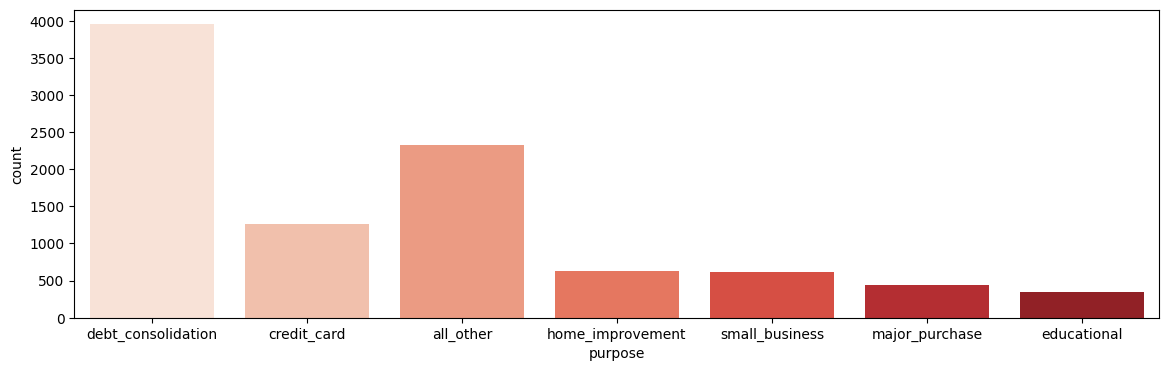

In [ ]:
#check number of each values in  purpose column on graph
plt.figure(figsize=(14,4))
sns.countplot(x="purpose",data=loan_data, palette="Reds")
plt.show()

In [ ]:
# Selecting numerical columns for correlation analysis
numerical_columns = loan_data.select_dtypes(include=['int', 'float']).columns

# Calculating correlation matrix
correlation_matrix = loan_data[numerical_columns].corr(method='spearman')

# Displaying correlation matrix
print("Correlation Matrix between numerical features:")
print(correlation_matrix)

# Running Spearman correlation test
print("\nSpearman Correlation Statistical Test:")
for col1 in numerical_columns:
    for col2 in numerical_columns:
        if col1 != col2:
            corr, p_value = spearmanr(loan_data[col1], loan_data[col2])
            print(f"{col1} vs {col2}: Spearman correlation coefficient = {corr}, p-value = {p_value}")

Correlation Matrix between numerical features:
                      credit.policy  int.rate  installment  log.annual.inc  \
credit.policy              1.000000 -0.287878     0.073698        0.029398   
int.rate                  -0.287878  1.000000     0.242914        0.041648   
installment                0.073698  0.242914     1.000000        0.431405   
log.annual.inc             0.029398  0.041648     0.431405        1.000000   
dti                       -0.080286  0.216114     0.062547       -0.059672   
fico                       0.352399 -0.744986     0.085257        0.107878   
days.with.cr.line          0.112885 -0.133584     0.201920        0.400251   
revol.util                -0.102636  0.472965     0.096013        0.053172   
inq.last.6mths            -0.433860  0.174137    -0.006740        0.030574   
delinq.2yrs               -0.057772  0.172677    -0.007541        0.029732   
pub.rec                   -0.048692  0.093887    -0.027854        0.013282   
not.fully.paid   

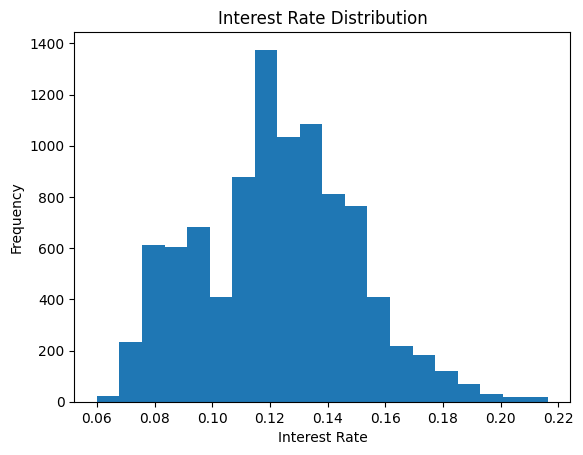

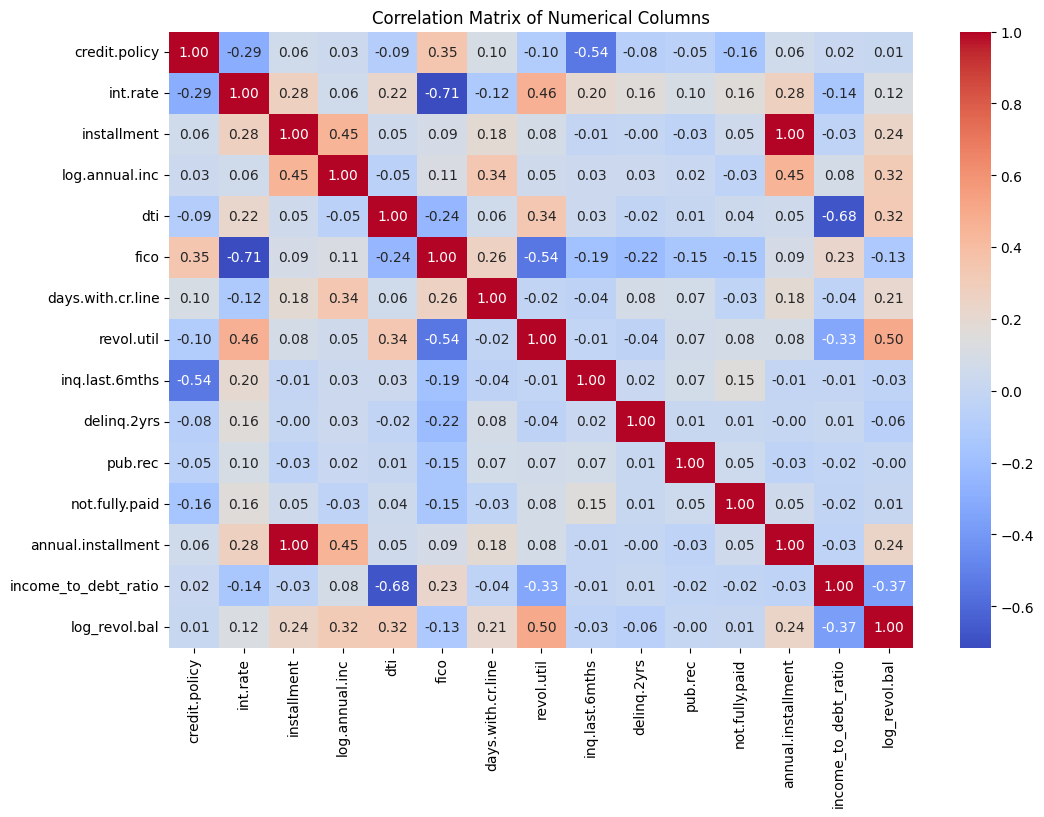

In [ ]:
plt.hist(loan_data['int.rate'], bins=20)
plt.title('Interest Rate Distribution')
plt.xlabel('Interest Rate')
plt.ylabel('Frequency')
plt.show()

# Calculate the correlation matrix for numerical columns
correlation_matrix = loan_data[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Columns')
plt.show()

Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.90      0.65      0.75      1611
           1       0.25      0.62      0.36       305

    accuracy                           0.65      1916
   macro avg       0.58      0.64      0.56      1916
weighted avg       0.80      0.65      0.69      1916

ROC-AUC: 0.6874723977572225
Confusion Matrix:
[[1046  565]
 [ 115  190]]

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1611
           1       0.91      0.96      0.93       305

    accuracy                           0.98      1916
   macro avg       0.95      0.97      0.96      1916
weighted avg       0.98      0.98      0.98      1916

ROC-AUC: 0.9977409408676008
Confusion Matrix:
[[1583   28]
 [  13  292]]

Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      161

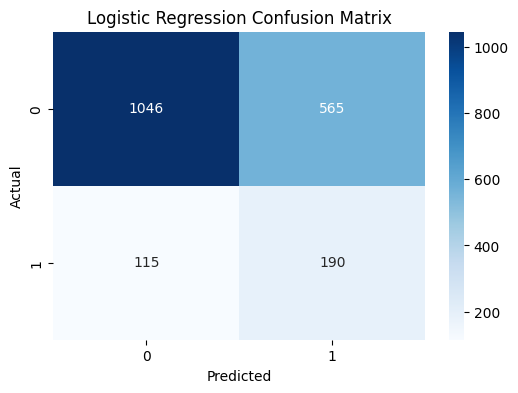

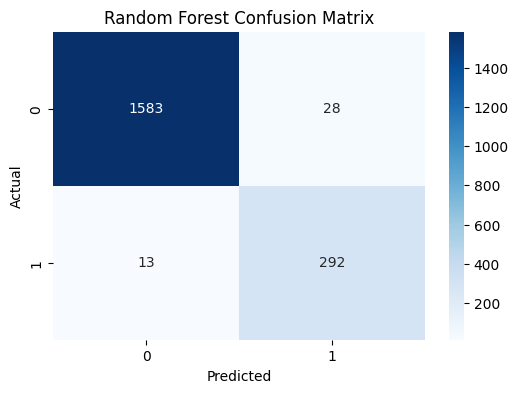

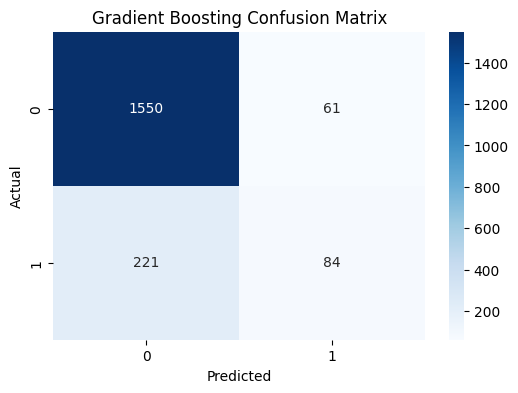

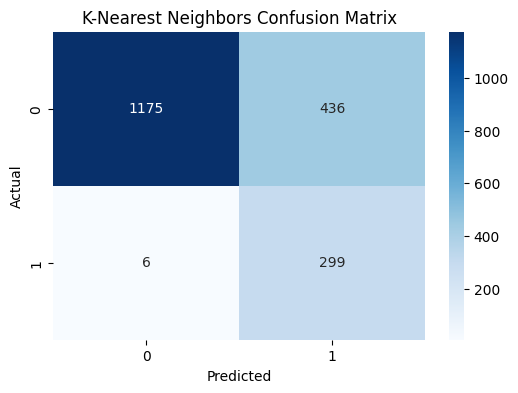

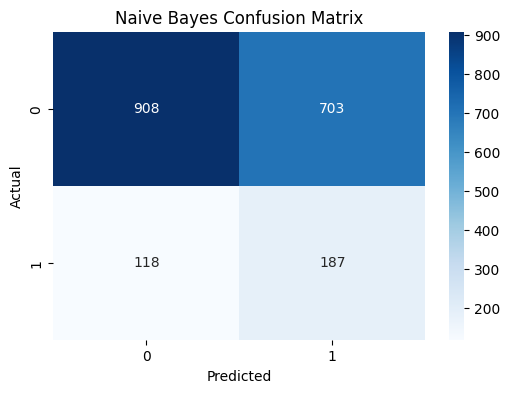

Model Rankings based on ROC-AUC:
1. Random Forest: 0.9977409408676008
2. K-Nearest Neighbors: 0.9732413428173112
3. Gradient Boosting: 0.8173967905078813
4. Logistic Regression: 0.6874723977572225
5. Naive Bayes: 0.6323147215353461
Model Rankings based on accuracy:
1. Random Forest: 0.9786012526096033
2. Gradient Boosting: 0.8528183716075156
3. K-Nearest Neighbors: 0.7693110647181628
4. Logistic Regression: 0.6450939457202505
5. Naive Bayes: 0.5715031315240083


In [ ]:
# Splitting the data
X = loan_data_encoded.drop('not.fully.paid', axis=1)
y = loan_data_encoded['not.fully.paid']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(max_iter=500, solver='saga', penalty='elasticnet', l1_ratio=0.5, C=1.0),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, min_samples_leaf=2, bootstrap=True),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=4, min_samples_split=5, min_samples_leaf=2, subsample=0.9),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB()
}

# Addressing class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train and evaluate models
model_performance = {}

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    model_performance[model_name] = {
        'accuracy': accuracy,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': cm
    }

    print(f"{model_name} Performance:")
    print(report)
    print(f"ROC-AUC: {roc_auc}")
    print(f"Confusion Matrix:\n{cm}\n")

# Plotting function for confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices for each model
for model_name, performance in model_performance.items():
    plot_confusion_matrix(performance['confusion_matrix'], f'{model_name} Confusion Matrix')

# Compare models based on ROC-AUC
roc_auc_scores = {model_name: performance['roc_auc'] for model_name, performance in model_performance.items()}
sorted_roc_auc_scores = sorted(roc_auc_scores.items(), key=lambda x: x[1], reverse=True)

print("Model Rankings based on ROC-AUC:")
for rank, (model_name, roc_auc) in enumerate(sorted_roc_auc_scores, start=1):
    print(f"{rank}. {model_name}: {roc_auc}")

# Compare models based on accuracy
accuracy_scores = {model_name: performance['accuracy'] for model_name, performance in model_performance.items()}
sorted_accuracy_scores = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)

print("Model Rankings based on accuracy:")
for rank, (model_name, accuracy) in enumerate(sorted_accuracy_scores, start=1):
    print(f"{rank}. {model_name}: {accuracy}")

K-Nearest Neighbors

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best K-Nearest Neighbors Parameters: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}
K-Nearest Neighbors Performance:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1611
           1       1.00      1.00      1.00       305

    accuracy                           1.00      1916
   macro avg       1.00      1.00      1.00      1916
weighted avg       1.00      1.00      1.00      1916

ROC-AUC: 1.0


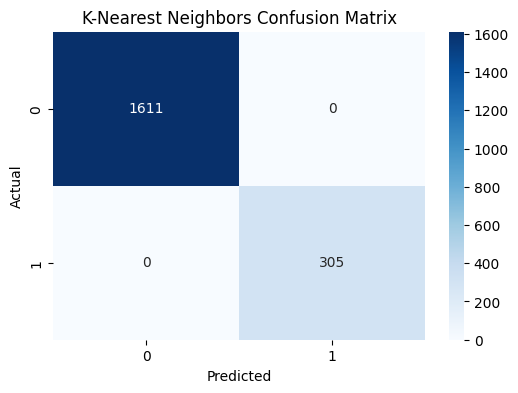

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Define a range of hyperparameters
knn_params = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the K-Nearest Neighbors model
knn = KNeighborsClassifier()

# Perform Grid Search with Cross-Validation
knn_grid = GridSearchCV(knn, knn_params, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
knn_grid.fit(X_resampled, y_resampled)

# Get the best model and its parameters
best_knn = knn_grid.best_estimator_
print(f"Best K-Nearest Neighbors Parameters: {knn_grid.best_params_}")

# Evaluate the best model
y_pred_knn = best_knn.predict(X_test)
y_pred_knn_prob = best_knn.predict_proba(X_test)[:, 1]
print("K-Nearest Neighbors Performance:")
print(classification_report(y_test, y_pred_knn))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_knn_prob)}")

# Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Plotting function for confusion matrix
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrix for K-Nearest Neighbors
plot_confusion_matrix(cm_knn, 'K-Nearest Neighbors Confusion Matrix')

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Gradient Boosting Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 5}
Gradient Boosting Performance:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      1611
           1       0.78      0.39      0.52       305

    accuracy                           0.88      1916
   macro avg       0.84      0.68      0.73      1916
weighted avg       0.88      0.88      0.87      1916

ROC-AUC: 0.8959815204892592


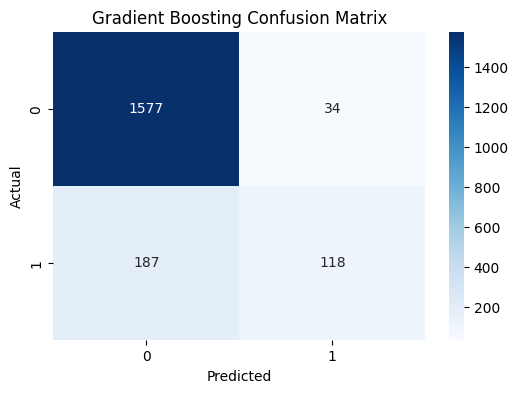

In [ ]:
gb_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [3, 4, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [1, 2]
}

# Initialize the Gradient Boosting model
gb = GradientBoostingClassifier(learning_rate=0.1, subsample=0.9)

# Perform Randomized Search with Cross-Validation
gb_random = RandomizedSearchCV(gb, gb_params, cv=5, scoring='roc_auc', n_iter=10, n_jobs=-1, verbose=2)
gb_random.fit(X_resampled, y_resampled)

# Get the best model and its parameters
best_gb = gb_random.best_estimator_
print(f"Best Gradient Boosting Parameters: {gb_random.best_params_}")

# Evaluate the best model
y_pred_gb = best_gb.predict(X_test)
y_pred_gb_prob = best_gb.predict_proba(X_test)[:, 1]
print("Gradient Boosting Performance:")
print(classification_report(y_test, y_pred_gb))
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_gb_prob)}")

# Confusion Matrix
cm_gb = confusion_matrix(y_test, y_pred_gb)

# Plot confusion matrix for Gradient Boosting
plot_confusion_matrix(cm_gb, 'Gradient Boosting Confusion Matrix')


In [ ]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
knn.fit(X_train_resampled, y_train_resampled)
gb.fit(X_train_resampled, y_train_resampled)
# Make predictions
y_pred_rf = rf.predict(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_gb = gb.predict(X_test)

# Probabilities for ROC-AUC
y_pred_rf_prob = rf.predict_proba(X_test)[:, 1]
y_pred_knn_prob = knn.predict_proba(X_test)[:, 1]
y_pred_gb_prob = gb.predict_proba(X_test)[:, 1]

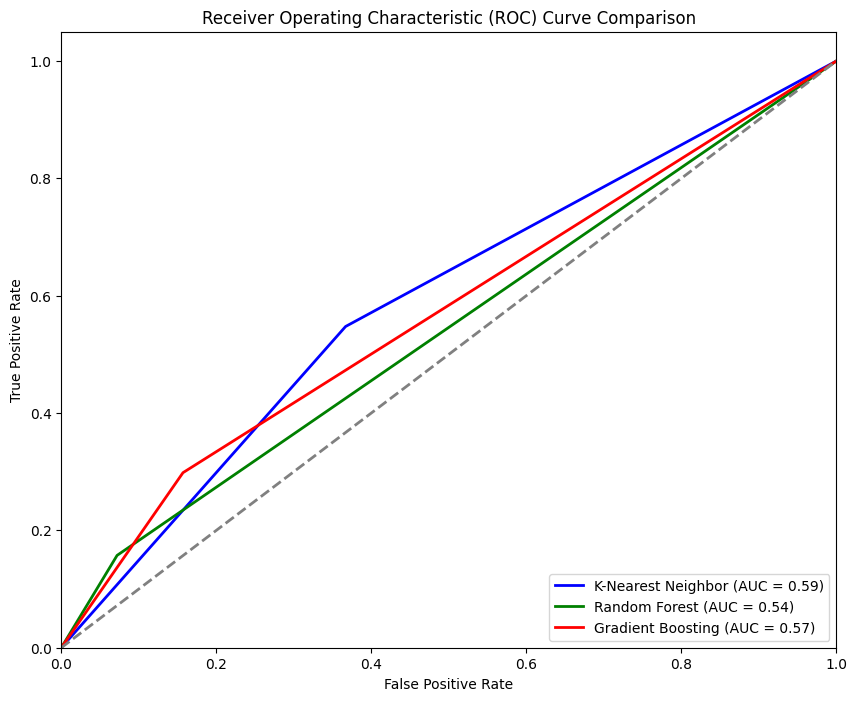

In [ ]:
# Calculate ROC curve and AUC for each model
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)


# Plotting the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'K-Nearest Neighbor (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_rf, tpr_rf, color='green', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, color='red', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')


plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.legend(loc="lower right")
plt.show()

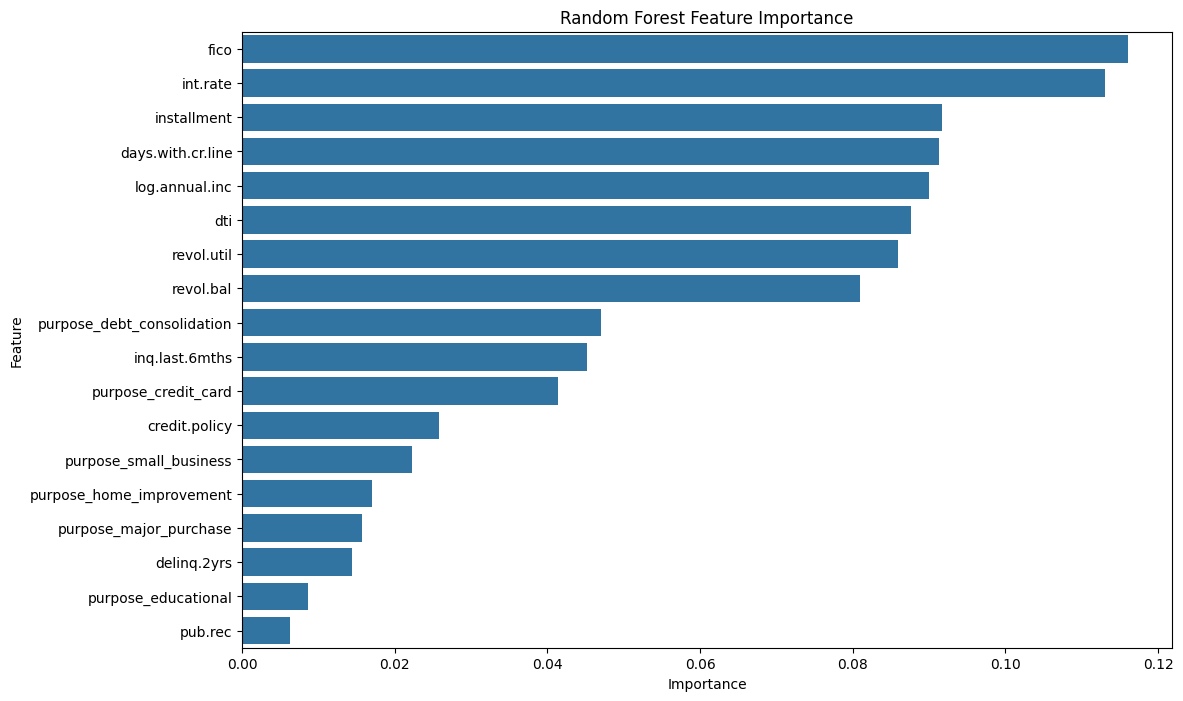

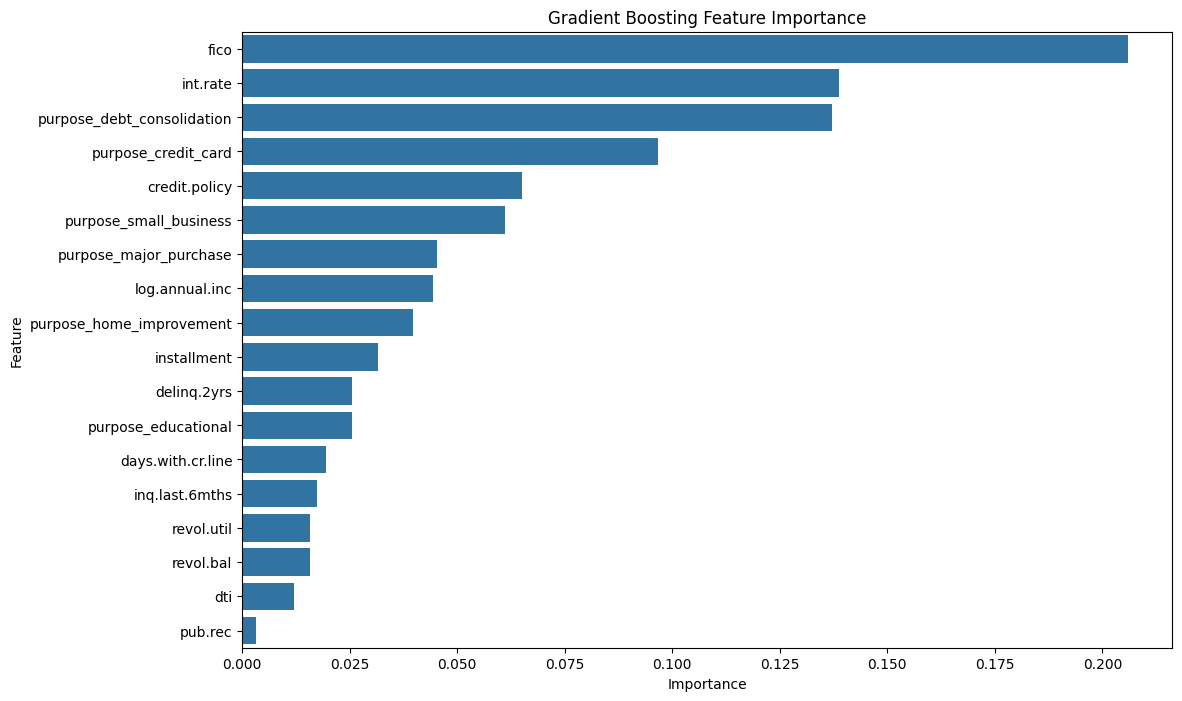

In [ ]:
# Feature importance for Random Forest
rf_importances = rf.feature_importances_
rf_feature_names = X.columns
rf_importance_df = pd.DataFrame({'Feature': rf_feature_names, 'Importance': rf_importances})
rf_importance_df = rf_importance_df.sort_values(by='Importance', ascending=False)

# Feature importance for Gradient Boosting
gb_importances = gb.feature_importances_
gb_feature_names = X.columns
gb_importance_df = pd.DataFrame({'Feature': gb_feature_names, 'Importance': gb_importances})
gb_importance_df = gb_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_importance_df)
plt.title('Random Forest Feature Importance')
plt.show()

# Plotting feature importance for Gradient Boosting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=gb_importance_df)
plt.title('Gradient Boosting Feature Importance')
plt.show()

Distribution of FICO Scores:
fico_bin
Poor            0
Fair         4221
Good         5212
Excellent     145
Name: count, dtype: int64


<ipython-input-15-b7b76b5d74b2>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fico_distribution.index, y=fico_distribution.values, palette='Blues_d')


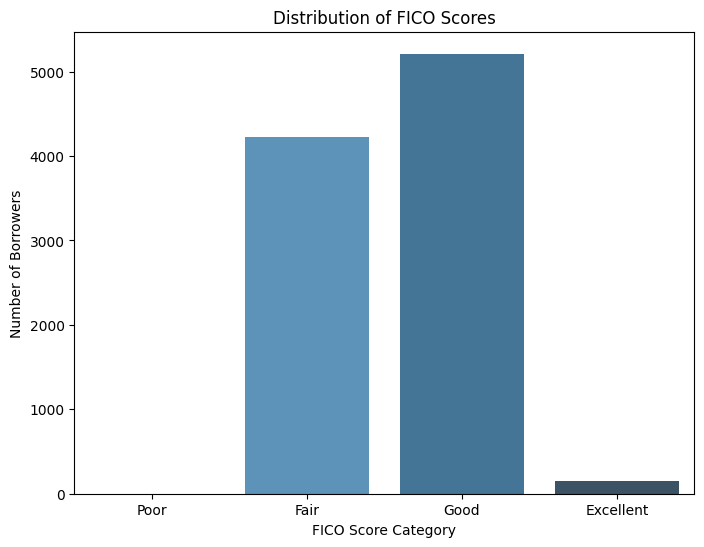

Distribution of Annual Incomes (Log Scale):
log.annual.inc
(7.54, 7.897]          2
(7.897, 8.246]         3
(8.246, 8.595]        11
(8.595, 8.944]        17
(8.944, 9.293]        41
(9.293, 9.642]       138
(9.642, 9.991]       322
(9.991, 10.34]       898
(10.34, 10.689]     1696
(10.689, 11.038]    2427
(11.038, 11.387]    2040
(11.387, 11.736]    1198
(11.736, 12.085]     484
(12.085, 12.434]     198
(12.434, 12.783]      61
(12.783, 13.132]      18
(13.132, 13.481]      14
(13.481, 13.83]        6
(13.83, 14.179]        2
(14.179, 14.528]       2
Name: count, dtype: int64


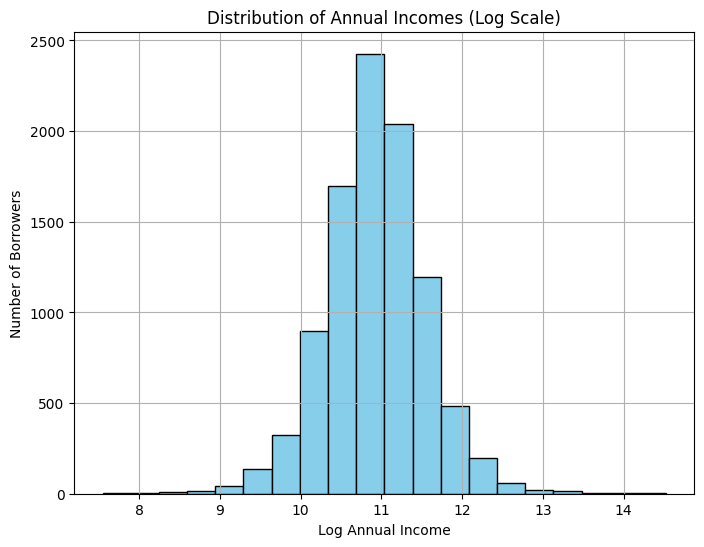

In [ ]:
# Bin the FICO scores
bins = [300, 600, 700, 800, 850]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
loan_data['fico_bin'] = pd.cut(loan_data['fico'], bins=bins, labels=labels, right=False)

# Analyze the distribution of FICO scores
fico_distribution = loan_data['fico_bin'].value_counts().sort_index()
print("Distribution of FICO Scores:")
print(fico_distribution)

# Plot the distribution of FICO scores
plt.figure(figsize=(8, 6))
sns.barplot(x=fico_distribution.index, y=fico_distribution.values, palette='Blues_d')
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score Category')
plt.ylabel('Number of Borrowers')
plt.show()

# Analyze the distribution of annual incomes (in logarithmic scale)
income_distribution = loan_data['log.annual.inc'].value_counts(bins=20).sort_index()
print("Distribution of Annual Incomes (Log Scale):")
print(income_distribution)

# Plot the distribution of annual incomes (in logarithmic scale)
plt.figure(figsize=(8, 6))
loan_data['log.annual.inc'].hist(bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Annual Incomes (Log Scale)')
plt.xlabel('Log Annual Income')
plt.ylabel('Number of Borrowers')
plt.show()

In [ ]:
# Create a DataFrame to show the predicted results
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted_RF': y_pred_rf,
    'Predicted_RF_Prob': y_pred_rf_prob,
    'Predicted_KNN': y_pred_knn,
    'Predicted_KNN_Prob': y_pred_knn_prob,
    'Predicted_GB': y_pred_gb,
    'Predicted_GB_Prob': y_pred_gb_prob
})

# Display the first few rows of the DataFrame
print(predictions_df.head())

# Summary of predicted results
print("\nSummary of Predicted Results (Random Forest):")
print(predictions_df[['Actual', 'Predicted_RF', 'Predicted_RF_Prob']].head())

print("\nSummary of Predicted Results (K-Nearest Neighbors):")
print(predictions_df[['Actual', 'Predicted_KNN', 'Predicted_KNN_Prob']].head())

print("\nSummary of Predicted Results (Gradient Boosting):")
print(predictions_df[['Actual', 'Predicted_GB', 'Predicted_GB_Prob']].head())

      Actual  Predicted_RF  Predicted_RF_Prob  Predicted_KNN  \
8558       0             1               0.67              1   
4629       0             0               0.17              0   
1383       1             0               0.14              0   
8142       0             0               0.18              0   
1768       0             0               0.06              0   

      Predicted_KNN_Prob  Predicted_GB  Predicted_GB_Prob  
8558                 1.0             1           0.675900  
4629                 0.0             0           0.405066  
1383                 0.0             0           0.326073  
8142                 0.0             0           0.384043  
1768                 0.0             0           0.226603  

Summary of Predicted Results (Random Forest):
      Actual  Predicted_RF  Predicted_RF_Prob
8558       0             1               0.67
4629       0             0               0.17
1383       1             0               0.14
8142       0            

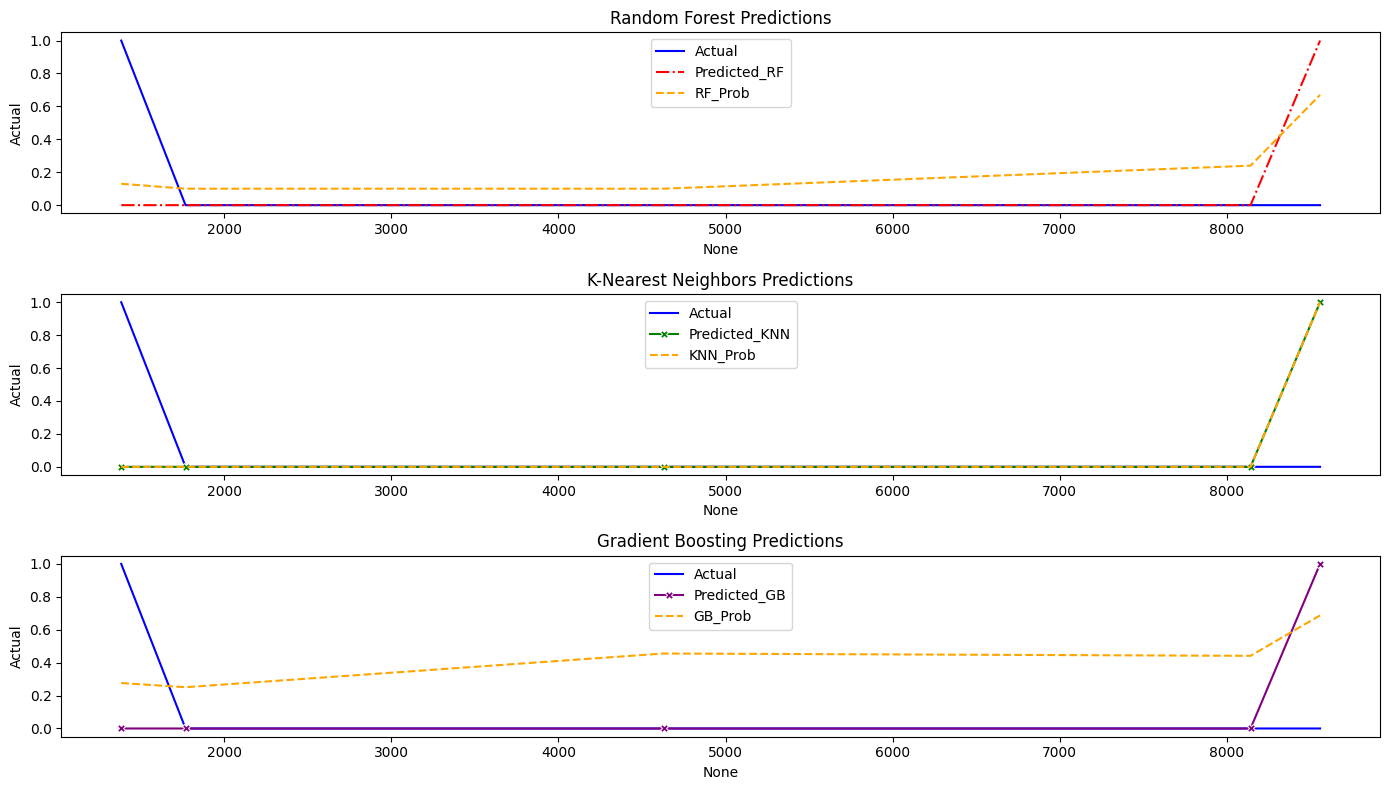

In [ ]:
# Provided data
data = {
    'Actual': [0, 0, 1, 0, 0],
    'Predicted_RF': [1, 0, 0, 0, 0],
    'Predicted_RF_Prob': [0.67, 0.10, 0.13, 0.24, 0.10],
    'Predicted_KNN': [1, 0, 0, 0, 0],
    'Predicted_KNN_Prob': [1.0, 0.0, 0.0, 0.0, 0.0],
    'Predicted_GB': [1, 0, 0, 0, 0],
    'Predicted_GB_Prob': [0.687005, 0.455550, 0.276111, 0.441451, 0.250791]
}

# Create a DataFrame
df = pd.DataFrame(data, index=[8558, 4629, 1383, 8142, 1768])

# Plotting
plt.figure(figsize=(14, 8))

# Plot Actual vs Predicted_RF
plt.subplot(3, 1, 1)
sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', color='blue', linestyle='-')
sns.lineplot(data=df, x=df.index, y='Predicted_RF', label='Predicted_RF', markers='X', color='red', linestyle='-.')
sns.lineplot(data=df, x=df.index, y='Predicted_RF_Prob', label='RF_Prob', color='orange', linestyle='--')
plt.title('Random Forest Predictions')
plt.legend()

# Plot Actual vs Predicted_KNN
plt.subplot(3, 1, 2)
sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', color='blue', linestyle='-')
sns.lineplot(data=df, x=df.index, y='Predicted_KNN', label='Predicted_KNN', marker='X', color='green', linestyle='-')
sns.lineplot(data=df, x=df.index, y='Predicted_KNN_Prob', label='KNN_Prob', color='orange', linestyle='--')
plt.title('K-Nearest Neighbors Predictions')
plt.legend()

# Plot Actual vs Predicted_GB
plt.subplot(3, 1, 3)
sns.lineplot(data=df, x=df.index, y='Actual', label='Actual', color='blue', linestyle='-')
sns.lineplot(data=df, x=df.index, y='Predicted_GB', label='Predicted_GB', marker='X', color='purple', linestyle='-')
sns.lineplot(data=df, x=df.index, y='Predicted_GB_Prob', label='GB_Prob', color='orange', linestyle='--')
plt.title('Gradient Boosting Predictions')
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-18-413233dabec1>:1: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=loan_data['int.rate'], shade=True)


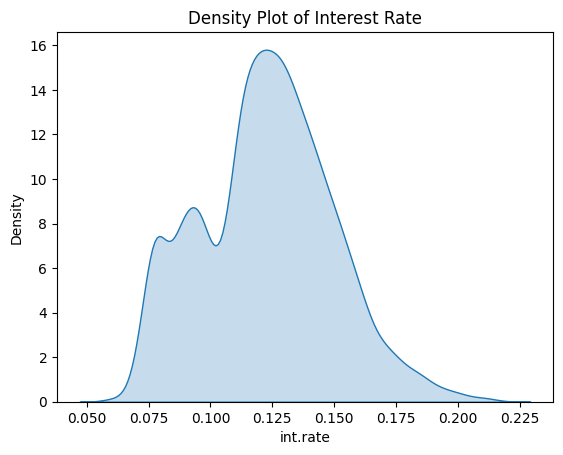

In [ ]:
sns.kdeplot(data=loan_data['int.rate'], shade=True)
plt.title('Density Plot of Interest Rate')
plt.show()

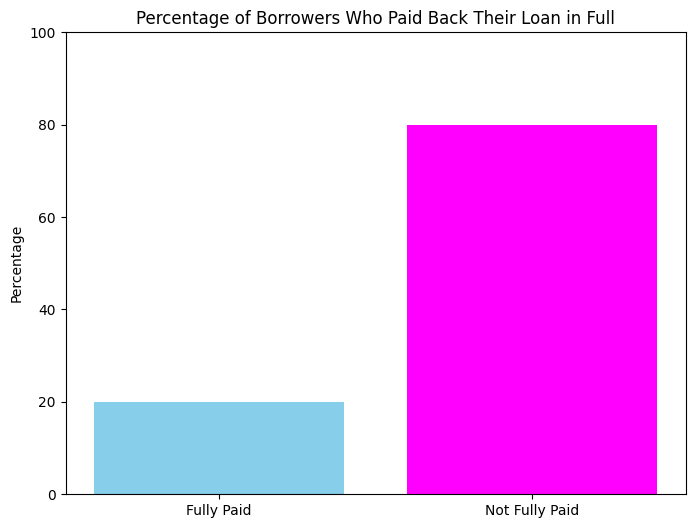

In [ ]:
# Convert to DataFrame
predicted_results = pd.DataFrame(data)

# Calculate the percentage of borrowers who paid back their loan in full
total_borrowers = len(predicted_results)
fully_paid_borrowers = predicted_results['Actual'].sum()
percent_fully_paid = (fully_paid_borrowers / total_borrowers) * 100

# Plot the percentage
plt.figure(figsize=(8, 6))
plt.bar(['Fully Paid', 'Not Fully Paid'], [percent_fully_paid, 100 - percent_fully_paid], color=['skyblue', 'fuchsia'])
plt.title('Percentage of Borrowers Who Paid Back Their Loan in Full')
plt.ylabel('Percentage')
plt.ylim(0, 100)
plt.show()

In [ ]:
corr = loan_data.iloc[:, 2:-1].corr()
corr.style.background_gradient(cmap='coolwarm')

,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid,annual.installment,income_to_debt_ratio,log_revol.bal,fico_bin_Fair,fico_bin_Good,fico_bin_Excellent
int.rate,1.000000,0.276140,0.056383,0.220006,-0.714821,-0.124022,0.464837,0.202780,0.156079,0.098162,0.159552,0.276140,-0.142203,0.116108,0.610671,-0.574599,-0.139254
installment,0.276140,1.000000,0.448102,0.050202,0.086039,0.183297,0.081356,-0.010419,-0.004368,-0.032760,0.049955,1.000000,-0.032304,0.239425,-0.087607,0.081515,0.023718
log.annual.inc,0.056383,0.448102,1.000000,-0.054065,0.114576,0.336896,0.054881,0.029171,0.029203,0.016506,-0.033439,0.448102,0.079116,0.315156,-0.077660,0.063242,0.057808
dti,0.220006,0.050202,-0.054065,1.000000,-0.241191,0.060101,0.337109,0.029189,-0.021792,0.006209,0.037362,0.050202,-0.678225,0.320353,0.152879,-0.121198,-0.127251
fico,-0.714821,0.086039,0.114576,-0.241191,1.000000,0.263880,-0.541289,-0.185293,-0.216340,-0.147592,-0.149666,0.086039,0.227568,-0.127849,-0.796687,0.716942,0.314993
days.with.cr.line,-0.124022,0.183297,0.336896,0.060101,0.263880,1.000000,-0.024239,-0.041736,0.081374,0.071826,-0.029237,0.183297,-0.036833,0.212178,-0.176086,0.143456,0.130820
revol.util,0.464837,0.081356,0.054881,0.337109,-0.541289,-0.024239,1.000000,-0.013880,-0.042740,0.066717,0.082088,0.081356,-0.327624,0.498591,0.409996,-0.365631,-0.175670
inq.last.6mths,0.202780,-0.010419,0.029171,0.029189,-0.185293,-0.041736,-0.013880,1.000000,0.021245,0.072673,0.149452,-0.010419,-0.011369,-0.034092,0.145717,-0.133277,-0.048864
delinq.2yrs,0.156079,-0.004368,0.029203,-0.021792,-0.216340,0.081374,-0.042740,0.021245,1.000000,0.009184,0.008881,-0.004368,0.014140,-0.058885,0.198668,-0.188929,-0.037161
pub.rec,0.098162,-0.032760,0.016506,0.006209,-0.147592,0.071826,0.066717,0.072673,0.009184,1.000000,0.048634,-0.032760,-0.015043,-0.003860,0.124988,-0.117389,-0.029384


In [ ]:
import joblib

loan_data = pd.read_csv('/content/loan_data.csv')

# Preprocessing the data
# Drop rows with missing values
loan_data.dropna(inplace=True)

# Binning the FICO scores
bins = [300, 600, 700, 800, 850]
labels = ['Poor', 'Fair', 'Good', 'Excellent']
loan_data['fico_bin'] = pd.cut(loan_data['fico'], bins=bins, labels=labels, right=False)

# One-Hot Encoding for the binned 'fico_bin' column
loan_data = pd.get_dummies(loan_data, columns=['fico_bin'], drop_first=True)

# Define feature columns
feature_columns = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'days.with.cr.line',
                   'revol.bal', 'revol.util', 'fico', 'fico_bin_Fair', 'fico_bin_Good', 'fico_bin_Excellent']

# Define target column
target_column = 'not.fully.paid'

# Split the data into training and testing sets
X = loan_data[feature_columns]
y = loan_data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train KNN model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# Train Gradient Boosting model
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# Train Random Forest model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# Save the models and scaler
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(gb, 'gb_model.pkl')
joblib.dump(rf, 'rf_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

# Function to predict loan repayment
def predict_loan_repayment():
    # Load the models and scaler
    knn = joblib.load('knn_model.pkl')
    gb = joblib.load('gb_model.pkl')
    rf = joblib.load('rf_model.pkl')
    scaler = joblib.load('scaler.pkl')

    while True:
        # Prompt user for FICO score and interest rate
        fico_score = input("Enter the FICO score (or 'q' to quit): ")
        if fico_score == 'q':
            break
        fico_score = float(fico_score)
        interest_rate = float(input("Enter the interest rate: "))

        # Example values for the other features (in practice, these should be provided by the user)
        installment = 250.0
        log_annual_inc = np.log(60000)
        dti = 18.0
        days_with_cr_line = 4560
        revol_bal = 15000
        revol_util = 75.0

        # Create a DataFrame from the input
        input_data = pd.DataFrame({
            'int.rate': [interest_rate],
            'installment': [installment],
            'log.annual.inc': [log_annual_inc],
            'dti': [dti],
            'days.with.cr.line': [days_with_cr_line],
            'revol.bal': [revol_bal],
            'revol.util': [revol_util],
            'fico': [fico_score]
        })

        # Process the FICO scores (binning)
        input_data['fico_bin'] = pd.cut(input_data['fico'], bins=bins, labels=labels, right=False)

        # One-Hot Encoding for the binned 'fico_bin' column
        encoded_fico_bin = pd.get_dummies(input_data['fico_bin'], prefix='fico_bin', drop_first=True)
        input_data = pd.concat([input_data.drop('fico_bin', axis=1), encoded_fico_bin], axis=1)

        # Add missing columns from one-hot encoding if necessary
        for col in ['fico_bin_Fair', 'fico_bin_Good', 'fico_bin_Excellent']:
            if col not in input_data.columns:
                input_data[col] = 0

        # Ensure the input data has the same feature names as during training
        input_data = input_data.reindex(columns=feature_columns, fill_value=0)

        # Scale the numerical features
        numerical_features = ['int.rate', 'installment', 'log.annual.inc', 'dti', 'days.with.cr.line', 'revol.bal', 'revol.util', 'fico', 'fico_bin_Fair', 'fico_bin_Good', 'fico_bin_Excellent']
        input_data[numerical_features] = scaler.transform(input_data[numerical_features])

        # Predict with each model
        knn_prediction = knn.predict(input_data)[0]
        gb_prediction = gb.predict(input_data)[0]
        rf_prediction = rf.predict(input_data)[0]

        # Print the results
        models = {'KNN': knn_prediction, 'Gradient Boosting': gb_prediction, 'Random Forest': rf_prediction}
        for model_name, prediction in models.items():
            result = "will fully pay the loan" if prediction == 0 else "will not fully pay the loan"
            print(f"{model_name}: The borrower with a FICO score of {fico_score} and an interest rate of {interest_rate} {result}.")

        print("\n")

# Example usage
predict_loan_repayment()

Enter the FICO score (or 'q' to quit): 700
Enter the interest rate: 0.125


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


KNN: The borrower with a FICO score of 700.0 and an interest rate of 0.125 will fully pay the loan.
Gradient Boosting: The borrower with a FICO score of 700.0 and an interest rate of 0.125 will not fully pay the loan.
Random Forest: The borrower with a FICO score of 700.0 and an interest rate of 0.125 will fully pay the loan.


Enter the FICO score (or 'q' to quit): 600
Enter the interest rate: 0.2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


KNN: The borrower with a FICO score of 600.0 and an interest rate of 0.2 will fully pay the loan.
Gradient Boosting: The borrower with a FICO score of 600.0 and an interest rate of 0.2 will not fully pay the loan.
Random Forest: The borrower with a FICO score of 600.0 and an interest rate of 0.2 will not fully pay the loan.


Enter the FICO score (or 'q' to quit): 800
Enter the interest rate: 0.3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


KNN: The borrower with a FICO score of 800.0 and an interest rate of 0.3 will fully pay the loan.
Gradient Boosting: The borrower with a FICO score of 800.0 and an interest rate of 0.3 will not fully pay the loan.
Random Forest: The borrower with a FICO score of 800.0 and an interest rate of 0.3 will fully pay the loan.


Enter the FICO score (or 'q' to quit): q
